In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import cuml
import cupy as cp

from cuml.manifold import TSNE
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.base import BaseEstimator
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

In [2]:
df = pd.read_csv('creditcard.csv')

data_features = df.iloc[:, 1:-1]
scaler = RobustScaler()
scaled_data = pd.DataFrame(
    data=scaler.fit_transform(data_features), 
    columns=data_features.columns
)

tsne = TSNE(n_components = 2, random_state=42)
tsne_transformed = tsne.fit_transform(scaled_data)
tsne_transformed = pd.DataFrame(tsne_transformed)

/home/yaroslav/.conda/envs/rapids-22.06/lib/python3.9/site-packages/cuml/internals/api_decorators.py:794: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [19:17:28.210841] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [65]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [41]:
sum(df['Class']==1) / (len(df))

0.001727485630620034

<AxesSubplot:>

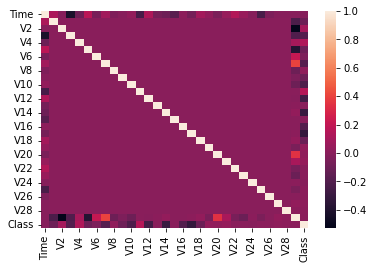

In [4]:
sns.heatmap(df.corr())

<AxesSubplot:xlabel='Time', ylabel='Count'>

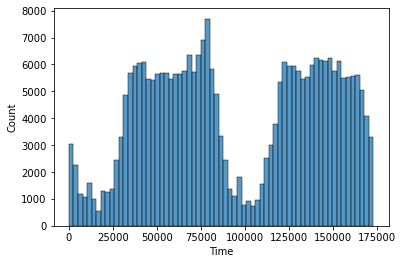

In [5]:
sns.histplot(df['Time'])

# Outlier std

In [60]:
def outlier_std(data, col, threshold=3):
    mean = data[col].mean()
    std = data[col].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    anomalies = pd.concat([data[col] > up_bound, data[col] < low_bound], axis=1).any(1)
    return anomalies, up_bound, low_bound

In [61]:
def get_column_outliers(data, columns=None, function=outlier_std, threshold=3, n_anom=1):
    if columns:
        columns_to_check = columns
    else:
        columns_to_check = data.columns
        
    outliers = pd.Series(data=[0]*len(data), index=data_features.index, name='is_outlier')
    
    for column in columns_to_check:
        anomalies, upper_bound, lower_bound = function(data, column, threshold=threshold)
        outliers[anomalies[anomalies].index] += 1
    
    outliers = outliers >= n_anom # сделка аномальна, если она аномальна по n_anom признакам
    
    return outliers

def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:   {:.2f}%".format(
            sum(outliers), 100*sum(outliers) / len(outliers)))    

In [172]:
def my_grid_search(data_features, outliers_func, n_anoms=np.arange(1, 31), thresholds=np.arange(3, 23)):
    best_f1_scores = []
    best_thresholds = []
    try:
        for n_anom in n_anoms:
            f1_list = np.array([])
            for i in thresholds:
                outliers = get_column_outliers(data_features,function=outliers_func, 
                                                                 threshold=i, n_anom=n_anom)
                new_df = df.join(outliers.astype(int))
                tp = len(new_df[(new_df['Class'] == 1)&(new_df['is_outlier'] == 1)])
                fn = len(new_df[(new_df['Class'] == 0)&(new_df['is_outlier'] == 1)])

                tn = len(new_df[(new_df['Class'] == 0)&(new_df['is_outlier'] == 0)])
                fp = len(new_df[(new_df['Class'] == 1)&(new_df['is_outlier'] == 0)])

                try:
                    precision = tp/(tp+fp)
                    recall = tp/(tp+fn)
                    f1 = 2 * ((precision*recall)/(precision+recall))
                    f1_list  = np.append(f1_list, f1)

                except ZeroDivisionError:
                    continue

            print(f'n_anom={n_anom}')
            print('Max f1:')
            print(np.max(f1_list))
            best_f1_scores.append(np.max(f1_list))

            threshold_variants = [i for i in thresholds]
            best_thresholds.append(threshold_variants[np.argmax(f1_list)])

            print(f'Optimal threshold = {threshold_variants[np.argmax(f1_list)]}')
            print("=="*20)
    # Независимо от остановки кода, лучшие результаты всё равно выведутся
    except KeyboardInterrupt:
        print("=="*20)
        print(f'Best f1 score = { np.round( np.max(best_f1_scores), 3) }')
        print(f'Best optimal threshold = {best_thresholds[np.argmax(best_f1_scores)]}')
        print(f'Best optimal n_anom = {[i for i in n_anoms][np.argmax(best_f1_scores)]}')
    except ValueError:
        print("=="*20)
        print(f'Best f1 score = { np.round( np.max(best_f1_scores), 3) }')
        print(f'Best optimal threshold = {best_thresholds[np.argmax(best_f1_scores)]}')
        print(f'Best optimal n_anom = {[i for i in n_anoms][np.argmax(best_f1_scores)]}')

## Перебор кол-ва сигм и кол-ва аномальных столбцов

In [173]:
my_grid_search(data_features, outlier_std)

n_anom=1
Max f1:
0.19663299663299663
Optimal threshold = 14
n_anom=2
Max f1:
0.22580645161290325
Optimal threshold = 13
n_anom=3
Max f1:
0.26150121065375304
Optimal threshold = 12
n_anom=4
Max f1:
0.2794871794871795
Optimal threshold = 11
n_anom=5
Max f1:
0.28222523744911804
Optimal threshold = 10
n_anom=6
Max f1:
0.29085872576177285
Optimal threshold = 9
n_anom=7
Max f1:
0.2942708333333333
Optimal threshold = 7
n_anom=8
Max f1:
0.3107019562715766
Optimal threshold = 5
n_anom=9
Max f1:
0.30749682337992373
Optimal threshold = 5
n_anom=10
Max f1:
0.3066298342541437
Optimal threshold = 5
n_anom=11
Max f1:
0.3137614678899082
Optimal threshold = 3
n_anom=12
Max f1:
0.31899265477439664
Optimal threshold = 3
n_anom=13
Max f1:
0.30626450116009285
Optimal threshold = 3
n_anom=14
Max f1:
0.29824561403508776
Optimal threshold = 3
n_anom=15
Max f1:
0.29149797570850206
Optimal threshold = 3
n_anom=16
Max f1:
0.2744525547445255
Optimal threshold = 3
n_anom=17
Max f1:
0.2511627906976744
Optimal thres

Возьмём за лучший результат при n_anom=12 и отколение в пределах n_sigmas>3

In [103]:
def estimate_anom_alg(tsne_transformed, outliers):
    tsne_transformed['predicted'] = outliers.astype('int')
    tsne_transformed['true'] = df['Class']
    tsne_transformed['perfomance'] = tsne_transformed['true'].astype(str) + \
                                                            tsne_transformed['predicted'].astype(str)
    tsne_transformed = tsne_transformed.replace(["00", "01", "11", "10"], ["TN", "FP", "TP", "FN"])
    
    groups = tsne_transformed.groupby('perfomance')
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Confusion plots', fontsize=20)
    
    for name, group in groups:
        if(name == "TN"):
            continue
        ax1.plot(group[0], group[1], marker='o', linestyle='', markersize=10, label=name)
    
    ax1.legend()
    groups = tsne_transformed.groupby('true')
    
    for name, group in groups:
        if(name == 0):
            continue
        ax2.plot(group[0], group[1], marker='o', linestyle='', markersize=10, label=name, color='green') 

    ax2.legend()
    
    ax1.set_xlim([-100,100])
    ax1.set_ylim([-100,100])
    
    ax2.set_xlim([-100,100])
    ax2.set_ylim([-100,100])
    
    fig.set_figheight(10)
    fig.set_figwidth(20)
    df_confusions = tsne_transformed.groupby(['perfomance']).size().reset_index(name='counts')
    df_confusions['percent'] = df_confusions['counts'] / sum(df_confusions['counts']) * 100
    print(df_confusions)

## Проведём оценку неточностей

  perfomance  counts    percent
0         FN     340   0.119379
1         FP     309   0.108495
2         TN  284006  99.718757
3         TP     152   0.053369


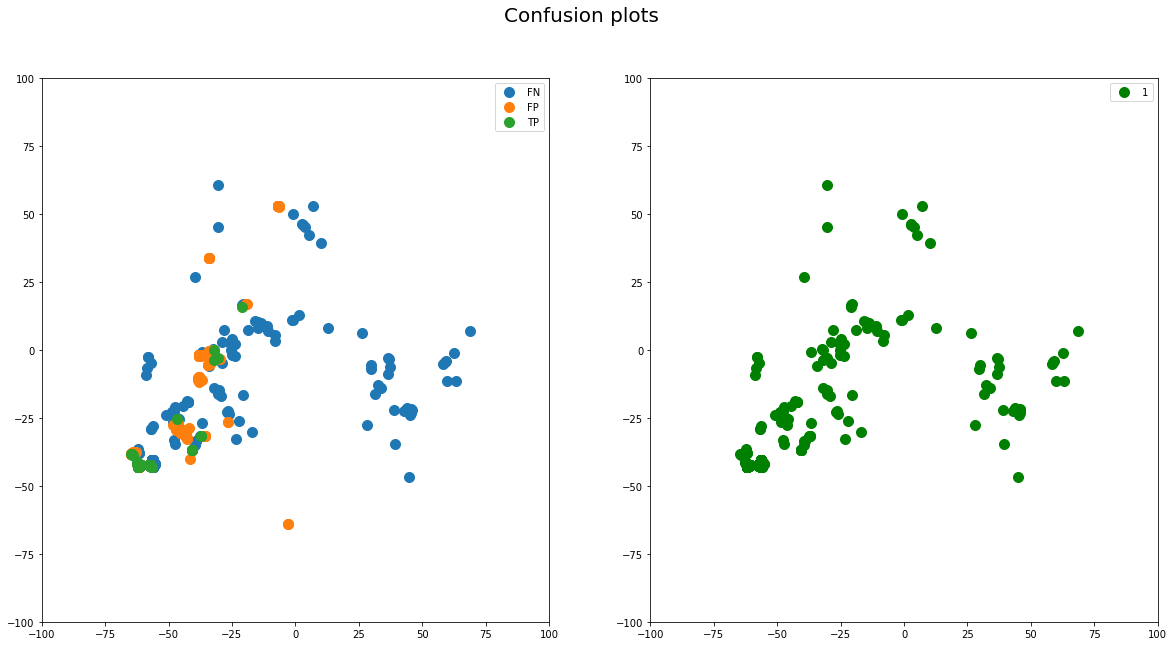

In [104]:
std_outliers = get_column_outliers(data_features, threshold=3, n_anom=12)
estimate_anom_alg(tsne_transformed, std_outliers)

# Distance Outliers

In [119]:
class DistanceOutliers(BaseEstimator):
    def __init__(self, metric='euclidean', percentile=90):
        self.metric = metric
        self.percentile = percentile
        
    def fit(self, X):
        self.centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
        distances_train = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        self.threshold = np.percentile(distances_train, self.percentile)
        
    def predict(self, X):
        distances = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        predictions = (distances > self.threshold).astype(int)
        return predictions

In [120]:
euclidian_model = DistanceOutliers(metric='euclidean', percentile=99)
euclidian_model.fit(df)
euclidian_outliers = euclidian_model.predict(df)
anomalies_report(euclidian_outliers)

Total number of outliers: 2849
Percentage of outliers:   1.00%


In [121]:
print(classification_report(df['Class'],euclidian_outliers.astype(int)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    284315
           1       0.00      0.00      0.00       492

    accuracy                           0.99    284807
   macro avg       0.50      0.50      0.50    284807
weighted avg       1.00      0.99      0.99    284807



  perfomance  counts    percent
0         FN     490   0.172046
1         FP    2847   0.999624
2         TN  281468  98.827627
3         TP       2   0.000702


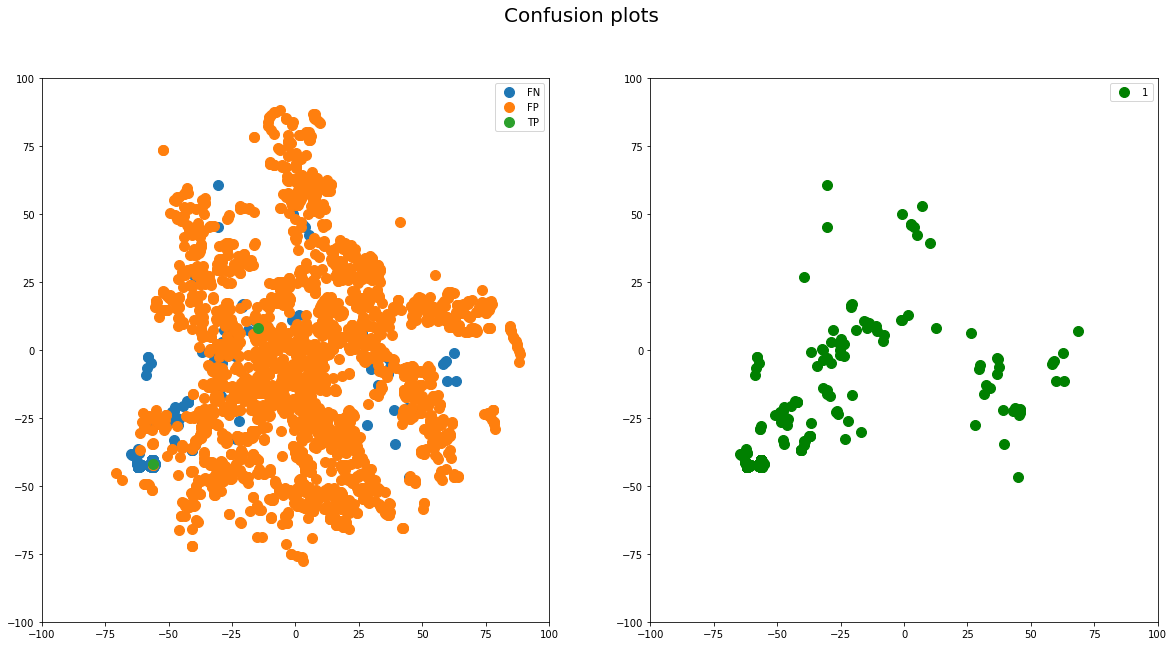

In [122]:
estimate_anom_alg(tsne_transformed, euclidian_outliers)

Эта модель нас не устраивает, так как мало TP

## Outlier IQR

In [39]:
def outlier_iqr(data, col, threshold=1.5):
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    up_bound = data[col].quantile(0.75) + (IQR * threshold)
    low_bound = data[col].quantile(0.25) - (IQR * threshold)
    anomalies = pd.concat([data[col] > up_bound, data[col] < low_bound], axis=1).any(1)
    return anomalies, up_bound, low_bound

In [ ]:
my_grid_search(data_features, outlier_iqr, thresholds=np.arange(1,5, 0.5))

In [84]:
iqr_outliers = get_column_outliers(data_features, function=outlier_iqr, n_anom=19, threshold=1)

  perfomance  counts
0         FN     315
1         FP     289
2         TN  284026
3         TP     177


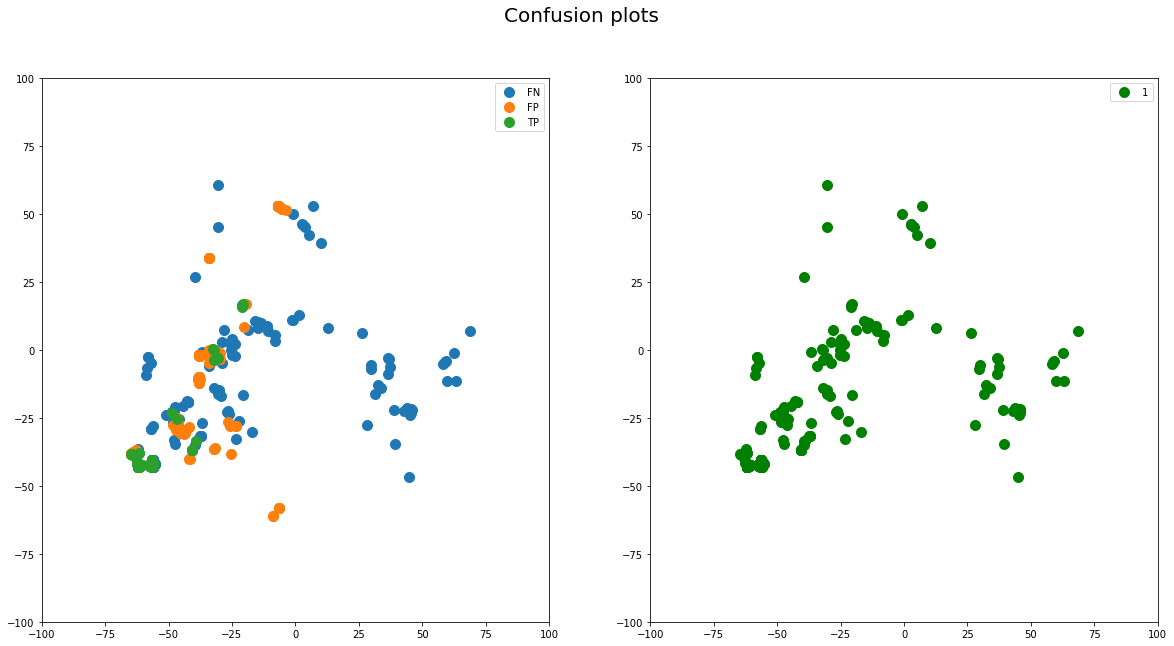

In [85]:
estimate_anom_alg(tsne_transformed, iqr_outliers)

# CUDA Supported DBSCAN

In [ ]:
%%time

outlier_percentage = 0.05

num_clusters = []
anomaly_percentage = []

eps = 5
eps_history = [eps]

while outlier_percentage > 0.002:    
    model = cuml.DBSCAN(eps=eps, max_mbytes_per_batch=5120).fit(scaled_data)
    labels = model.labels_
    num_clusters.append(len(np.unique(labels))-1)
    labels = np.array([1 if label == -1 else 0 for label in labels])

    # запишем предыдущий prev_outlier_perc, для обновления pbar
    prev_outlier_perc = outlier_percentage 
    outlier_percentage = sum(labels==1) / len(labels)
    eps += 0.25
    eps_history.append(eps)
    anomaly_percentage.append(outlier_percentage)
    print(outlier_percentage)

In [ ]:
iterations = eps_history[:-1]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epsilon')
ax1.set_ylabel('number of clusters', color=color)
ax1.plot(iterations, num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('anomaly percentage', color=color)  
ax2.plot(iterations, anomaly_percentage, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

In [16]:
model = cuml.DBSCAN(eps=6).fit(scaled_data)
labels = model.labels_
labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

  perfomance  counts
0         FN     300
1         FP    2998
2         TN  281317
3         TP     192


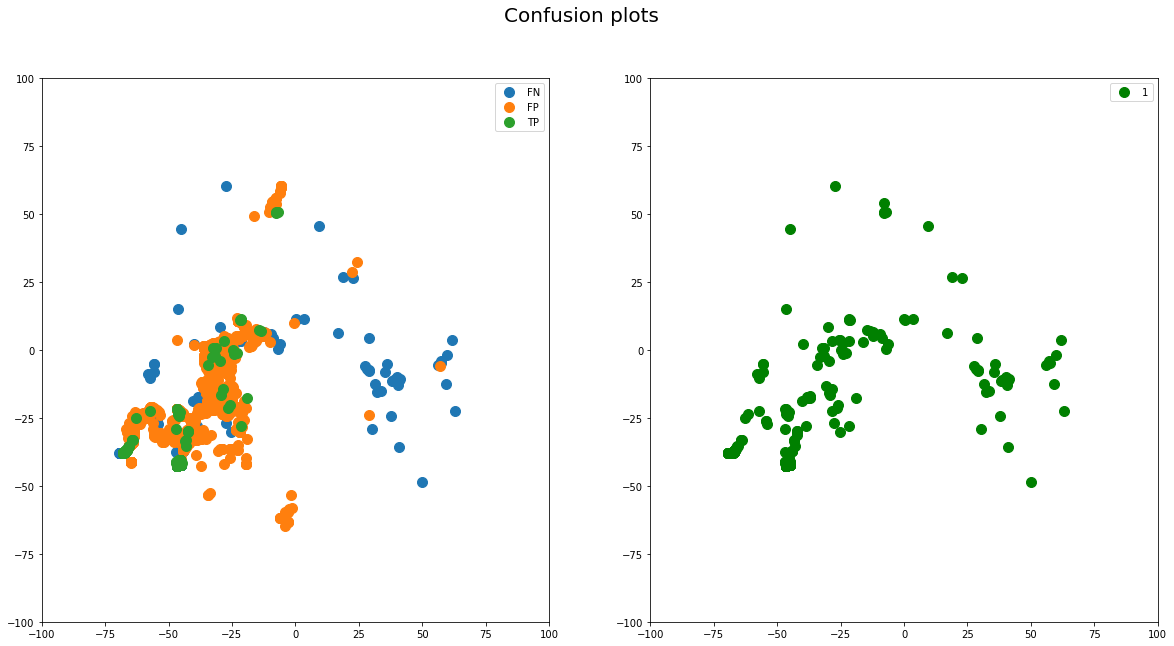

In [34]:
density_outlier = np.array([1 if label == -1 else 0 for label in model.labels_])
estimate_anom_alg(tsne_transformed, density_outlier)

## IsolationForest

In [68]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=100, contamination=0.005,
                                   max_features=10, bootstrap=True)
isolation_forest.fit(scaled_data)

isolation_outliers = isolation_forest.predict(scaled_data)
isolation_outliers = np.array([1 if label == -1 else 0 for label in isolation_outliers])

/home/yaroslav/.conda/envs/rapids-22.06/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


  perfomance  counts
0         FN     284
1         FP    1217
2         TN  283098
3         TP     208


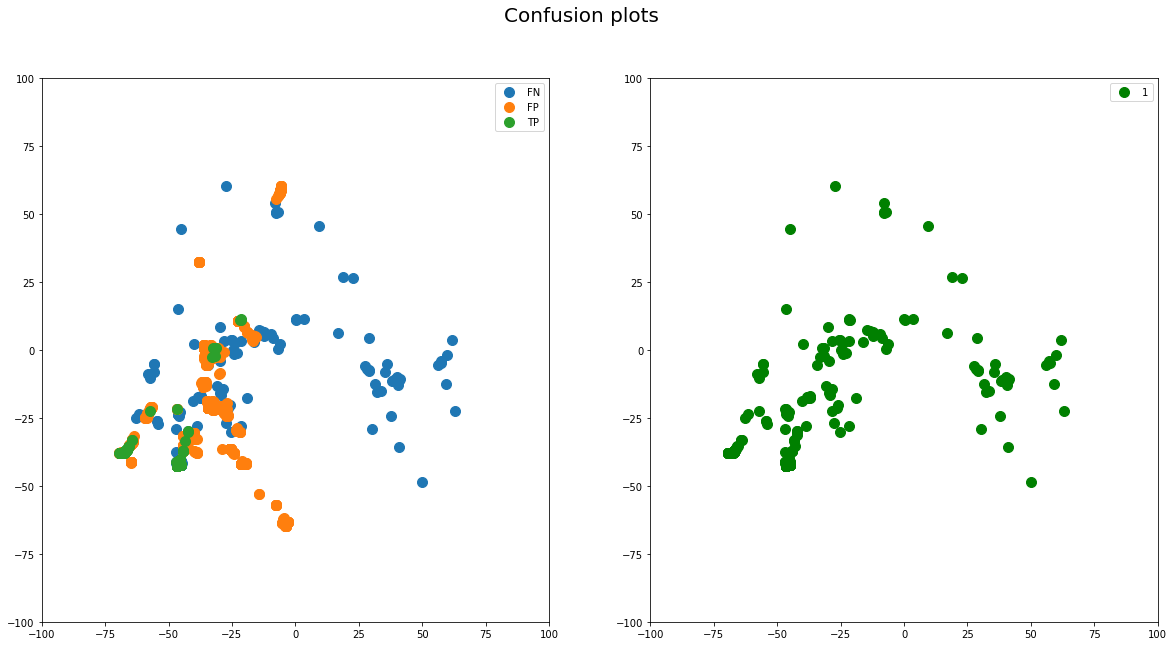

In [69]:
estimate_anom_alg(tsne_transformed, isolation_outliers)

## OneClassSVM

In [6]:
from sklearn.svm import OneClassSVM

one_class_svm = OneClassSVM(nu=0.05, gamma='auto')
one_class_svm.fit(scaled_data)
svm_outliers = one_class_svm.predict(scaled_data)
svm_outliers = np.array([1 if label == -1 else 0 for label in svm_outliers])

  perfomance  counts
0         FN      69
1         FP   13830
2         TN  270485
3         TP     423


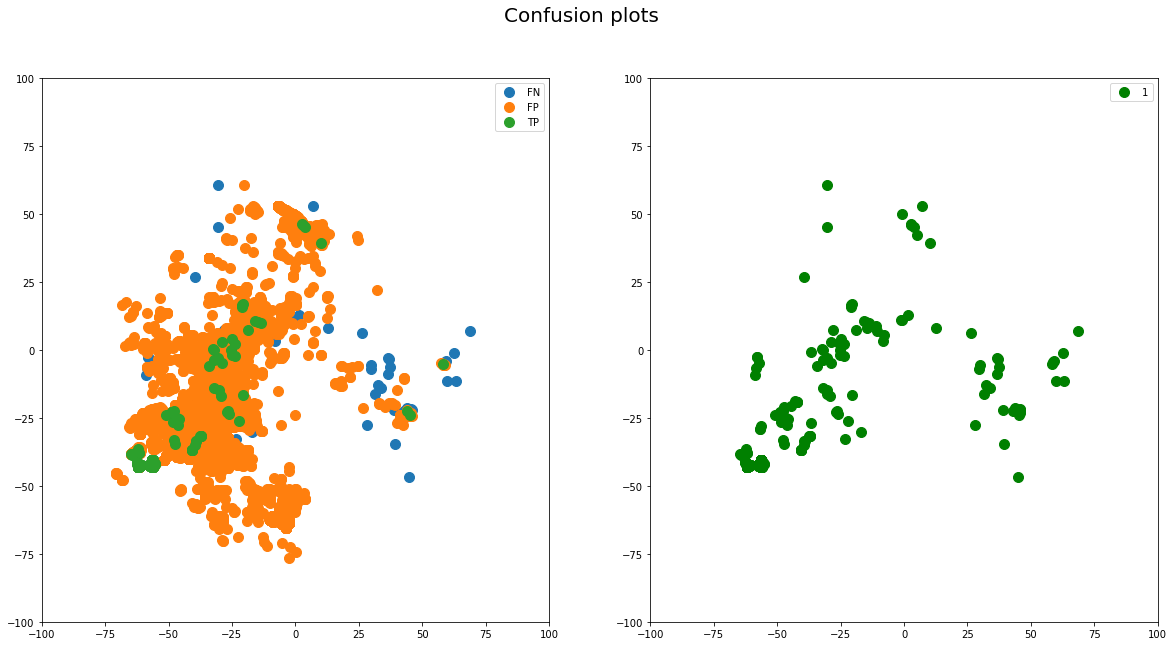

In [7]:
estimate_anom_alg(tsne_transformed, svm_outliers)